In [1]:
import torch, torchtext
from torchtext.functional import to_tensor
from torchtext.transforms import SentencePieceTokenizer
xlmr_base = torchtext.models.XLMR_BASE_ENCODER
model = xlmr_base.get_model()
transform = xlmr_base.transform()
input_batch = ["Hello world", "How are you!"]
model_input = to_tensor(transform(input_batch), padding_value=1)
output = model(model_input)
output.shape

torch.Size([2, 6, 768])

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm

from models import TextClassificationModel, zip_ssl
from datasets import AGNEWS
from utils import train, eval, acc, nomean

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
EPOCHS = 30
LR = 1e-3
BATCH_SIZE = 2048
EMBED_DIM = 64

In [5]:
criterion = nn.MSELoss()
LR=1e-5

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
# from utils import train

# Initialize RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')
roberta_model.to(device)

# Define the optimizer for the whole model (both RoBERTa and the classification head)
optimizer = optim.AdamW(list(roberta_model.parameters()), lr=LR)

# Function to get RoBERTa embeddings for a list of sentences
def model(sentences):
    # Tokenize the sentences
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the device

    # Get the embeddings (without using torch.no_grad())
    outputs = roberta_model(**inputs, output_hidden_states=True)
    del inputs
    torch.cuda.empty_cache()
    embeddings = outputs.hidden_states[-1]  # Last layer embeddings

    # Average the embeddings along the max_sequence_length dimension
    embeddings_avg = embeddings.mean(dim=1)

    return embeddings_avg

# Assuming you have defined the AGNEWS class and its methods correctly
ds = AGNEWS()
BATCH_SIZE = 16
train_loader, val_loader, test_loader = ds.loader(BATCH_SIZE, ssl=True)


/home/josegfer/miniconda3/envs/jiang2023low/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from torch.functional import F

def pearson(delta, ncd):
    vx = delta - torch.mean(delta)
    vy = ncd - torch.mean(ncd)

    return F.cosine_similarity(vx, vy, dim = 0)

In [8]:
def train(model, loader, criterion, optimizer, ssl = False):
    cost = 0
    corr = 0
    log = []
    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(loader)):
        if ssl:
            btsz = len(offsets) // 2
            h = model(label)
            delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
            # print(idx, delta.mean())
            loss = criterion(delta, ncd)
        else:
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)

        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        log.append([loss.item(), pearson(delta, ncd).detach().cpu(), delta.mean().detach().cpu()])
        cost += loss.item()
        # corr += pearson(delta, ncd).detach().cpu()
    # return cost / loader.dataset.__len__(), corr / loader.__len__(), log
    return cost / loader.dataset.__len__(), log

0it [00:00, ?it/s]

7125it [14:25,  8.23it/s]


3.5396659922474086e-05


7125it [06:59, 16.99it/s]
375it [00:14, 26.62it/s]
475it [00:18, 26.20it/s]


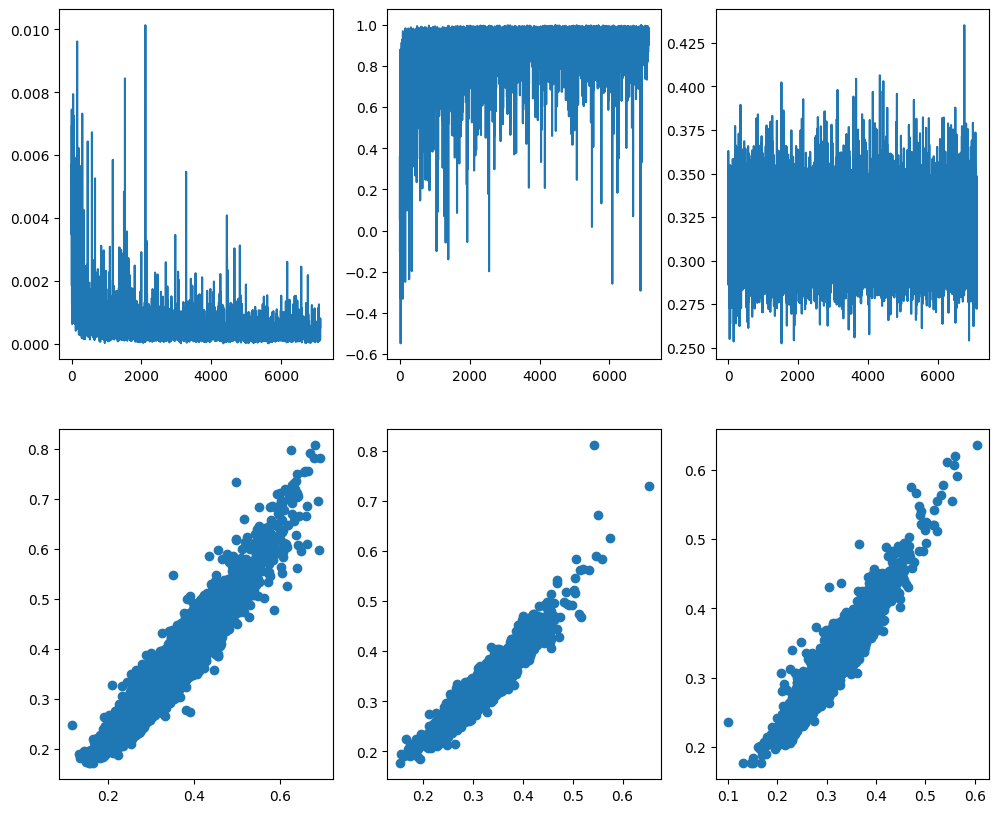

tensor(0.9484) tensor(0.9458) tensor(0.9399)
0.7593333333333333 0.7656578947368421


7125it [14:28,  8.20it/s]


1.854844955797537e-05


7125it [06:59, 16.98it/s]
375it [00:13, 26.94it/s]
475it [00:17, 26.42it/s]


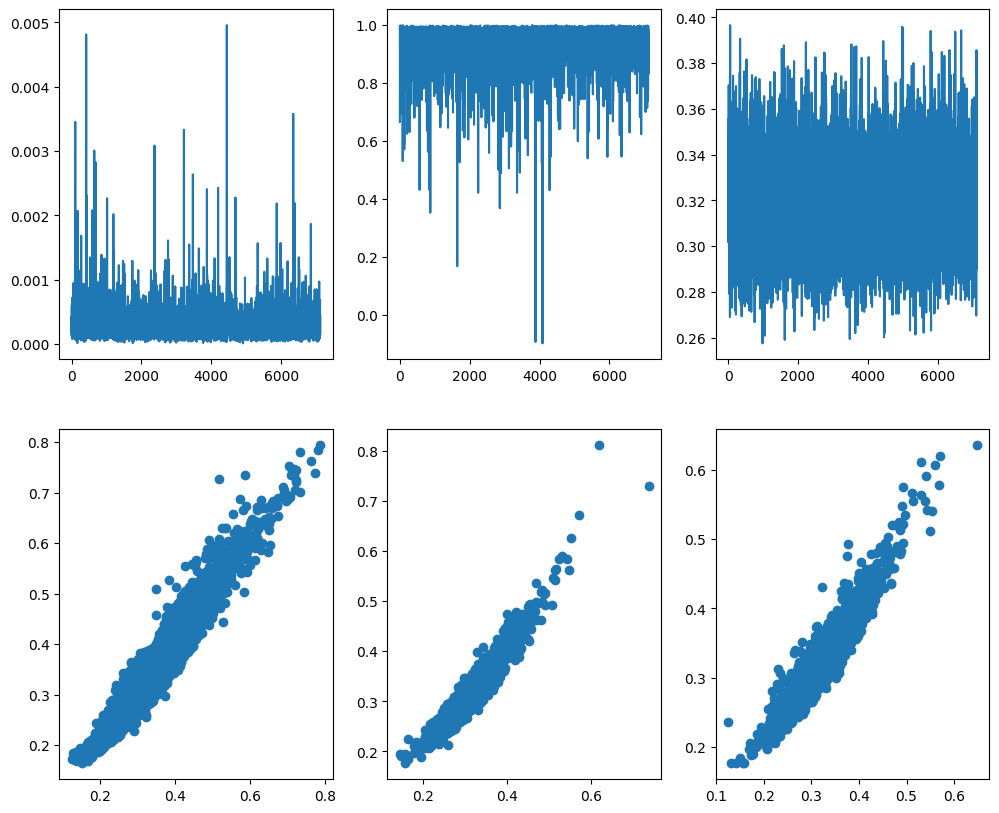

tensor(0.9571) tensor(0.9556) tensor(0.9474)
0.7123333333333334 0.7147368421052631


7125it [14:29,  8.19it/s]


1.5849036211452663e-05


7125it [07:02, 16.85it/s]
375it [00:13, 26.82it/s]
475it [00:18, 26.15it/s]


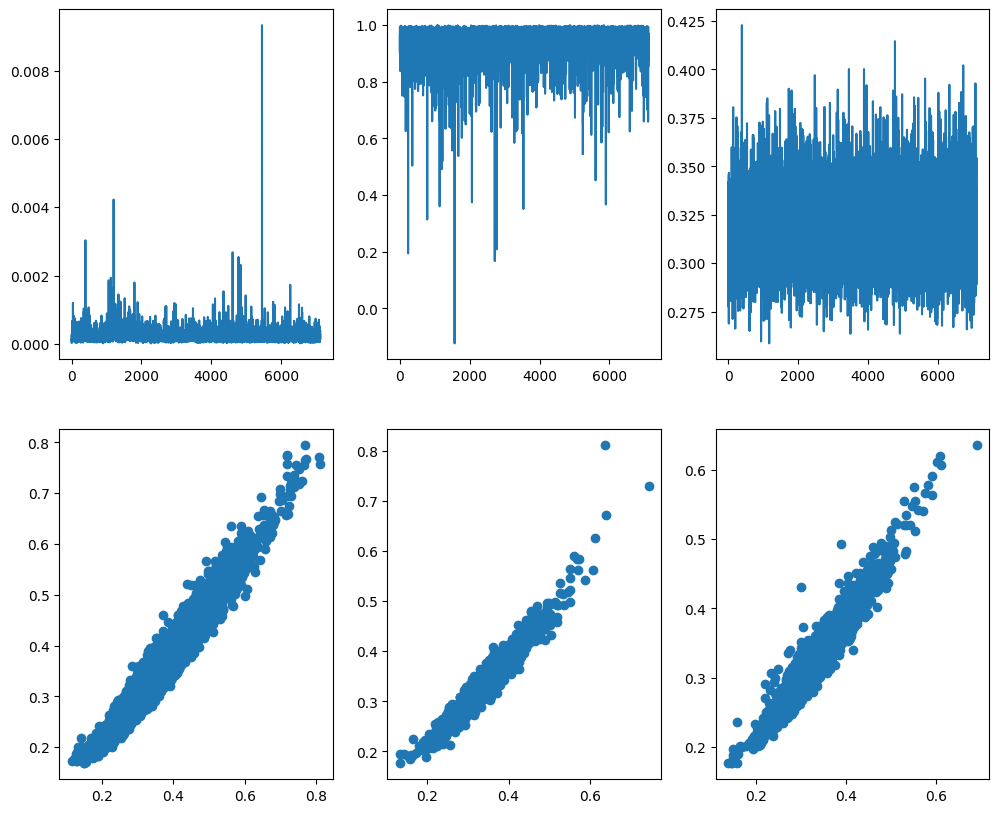

tensor(0.9691) tensor(0.9655) tensor(0.9611)
0.6801666666666667 0.689078947368421


7125it [14:29,  8.19it/s]


1.3315315841346251e-05


7125it [07:08, 16.61it/s]
375it [00:13, 26.90it/s]
475it [00:18, 26.17it/s]


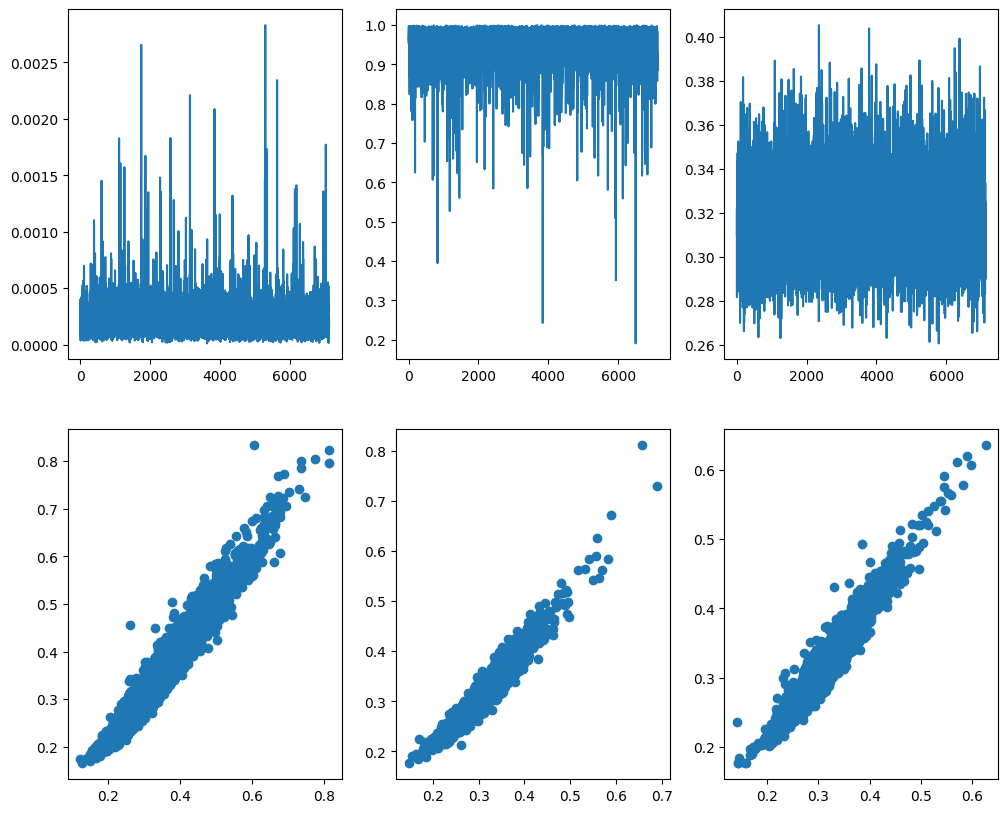

tensor(0.9660) tensor(0.9647) tensor(0.9600)
0.6836666666666666 0.6855263157894737


7125it [14:28,  8.20it/s]


1.2412120723702333e-05


7125it [07:03, 16.84it/s]
375it [00:13, 26.90it/s]
475it [00:18, 25.59it/s]


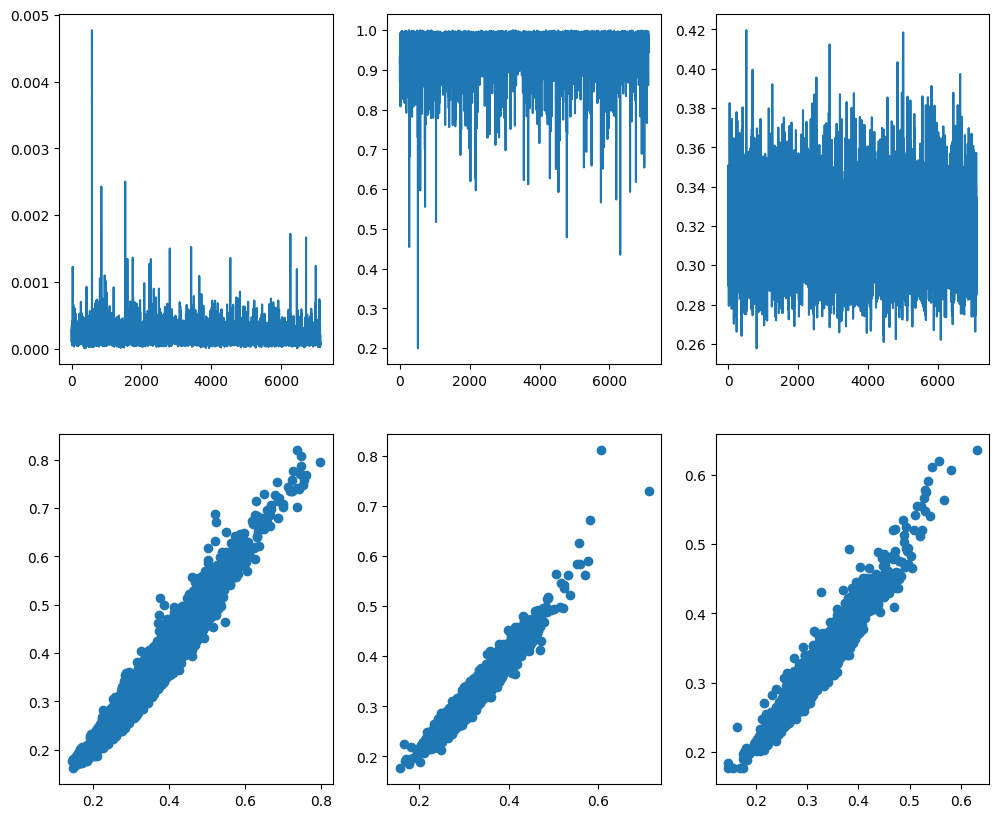

tensor(0.9689) tensor(0.9665) tensor(0.9597)
0.6346666666666667 0.6388157894736842


7125it [14:29,  8.20it/s]


1.1554510409113342e-05


7125it [07:01, 16.90it/s]
375it [00:13, 26.93it/s]
475it [00:18, 25.93it/s]


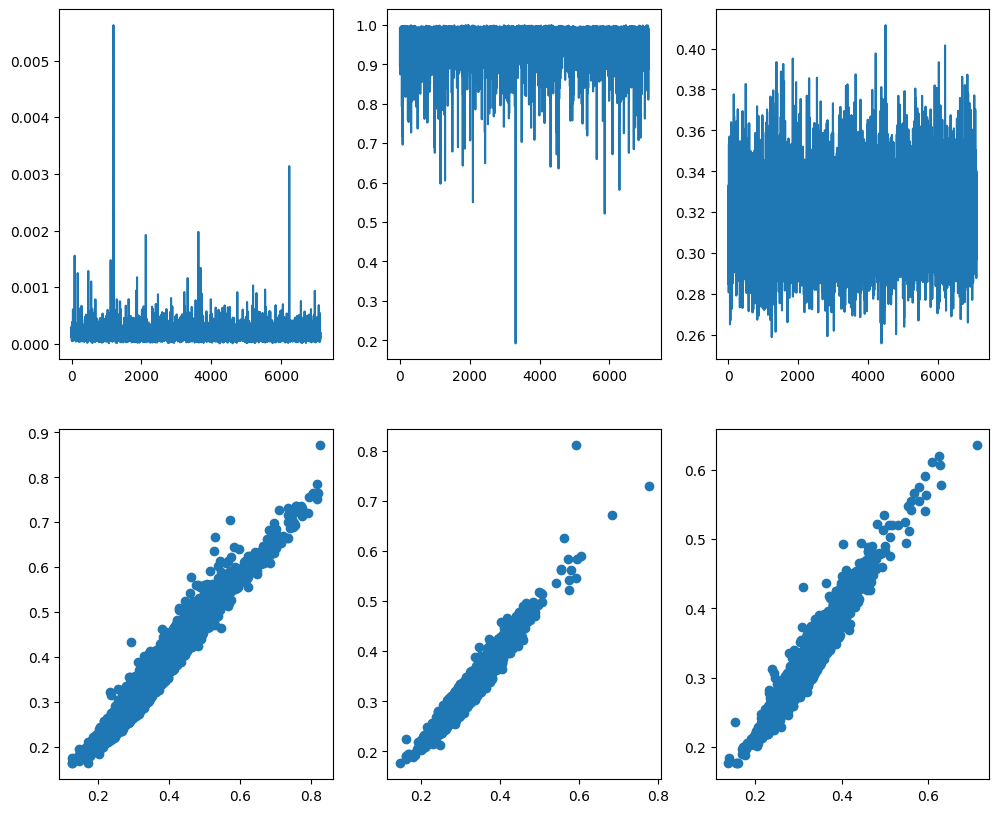

tensor(0.9724) tensor(0.9692) tensor(0.9646)
0.6198333333333333 0.6232894736842105


7125it [14:29,  8.19it/s]


1.1059526118650977e-05


7125it [07:04, 16.80it/s]
375it [00:14, 26.78it/s]
475it [00:18, 25.85it/s]


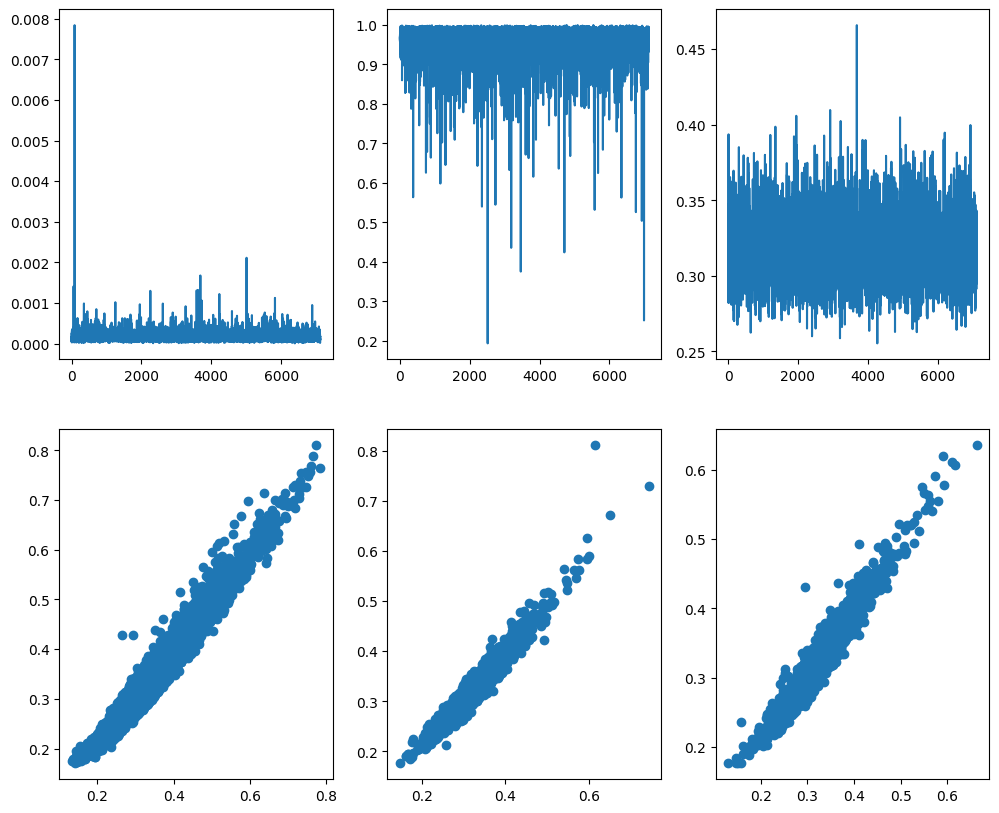

tensor(0.9736) tensor(0.9706) tensor(0.9676)
0.6068333333333333 0.603421052631579


7125it [14:31,  8.18it/s]


1.0216761829177925e-05


7125it [07:04, 16.80it/s]
375it [00:14, 26.74it/s]
475it [00:18, 25.52it/s]


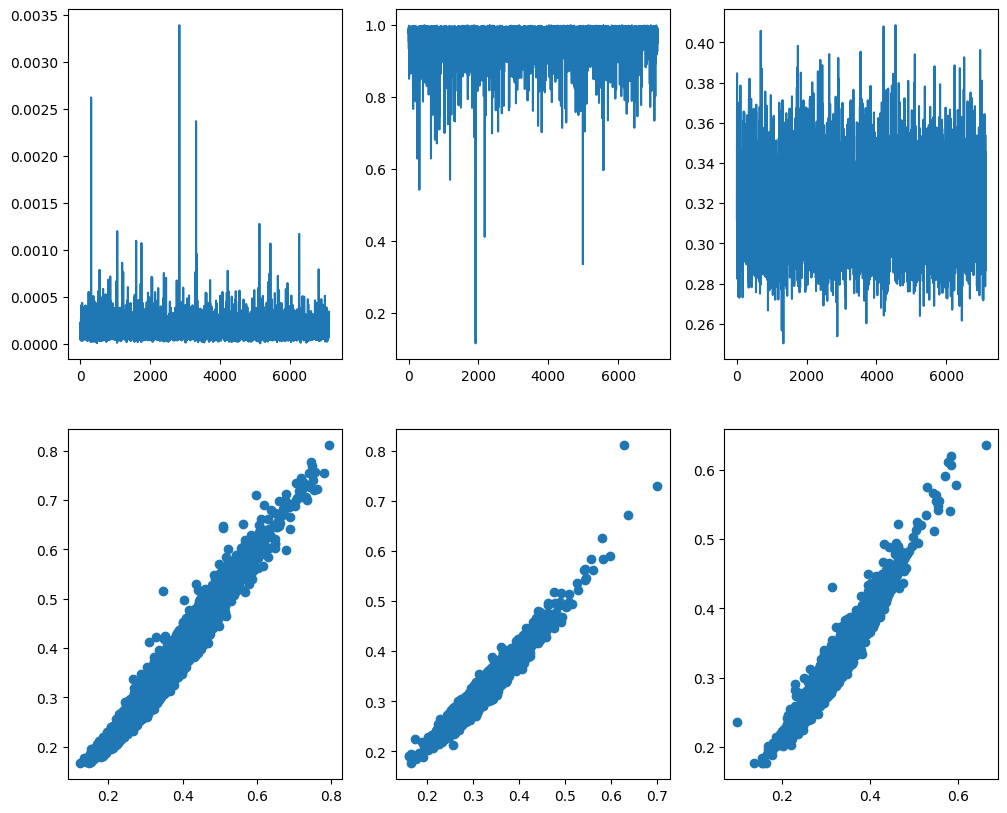

tensor(0.9739) tensor(0.9725) tensor(0.9667)
0.6313333333333333 0.6346052631578948


7125it [14:30,  8.18it/s]


1.017324105637192e-05


7125it [07:04, 16.79it/s]
375it [00:14, 26.78it/s]
475it [00:18, 25.54it/s]


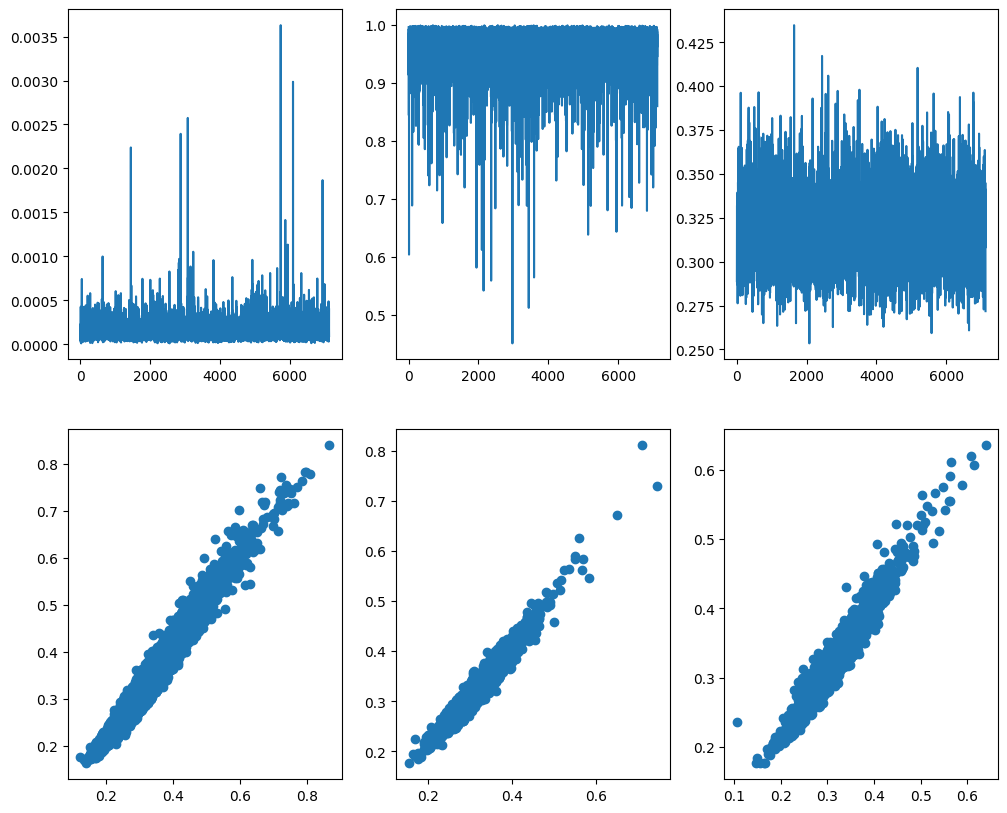

tensor(0.9743) tensor(0.9734) tensor(0.9682)
0.5871666666666666 0.5953947368421053


7125it [14:29,  8.20it/s]


1.0113472233945032e-05


7125it [07:05, 16.76it/s]
375it [00:14, 26.71it/s]
475it [00:18, 25.41it/s]


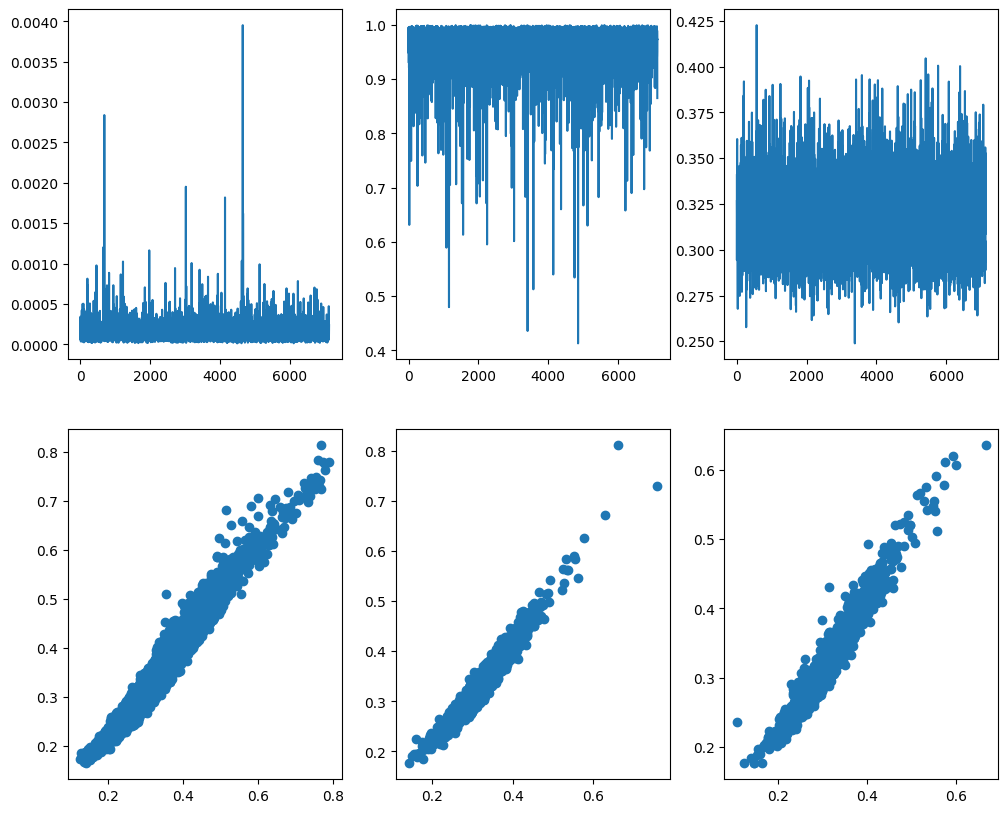

tensor(0.9739) tensor(0.9735) tensor(0.9674)
0.588 0.58


7125it [14:29,  8.20it/s]


9.798145909754614e-06


7125it [07:04, 16.77it/s]
375it [00:14, 26.70it/s]
475it [00:18, 25.28it/s]


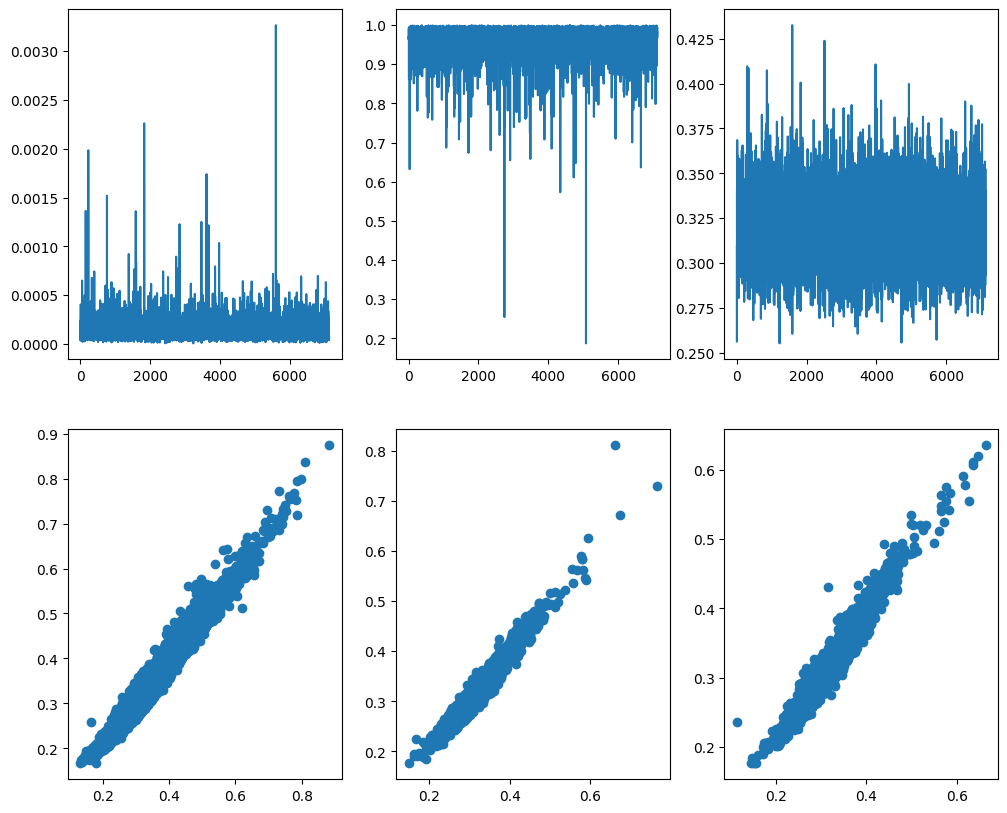

tensor(0.9766) tensor(0.9748) tensor(0.9713)
0.5891666666666666 0.5803947368421053


7125it [14:30,  8.19it/s]


9.291441121237304e-06


7125it [07:02, 16.87it/s]
375it [00:14, 26.49it/s]
475it [00:18, 25.29it/s]


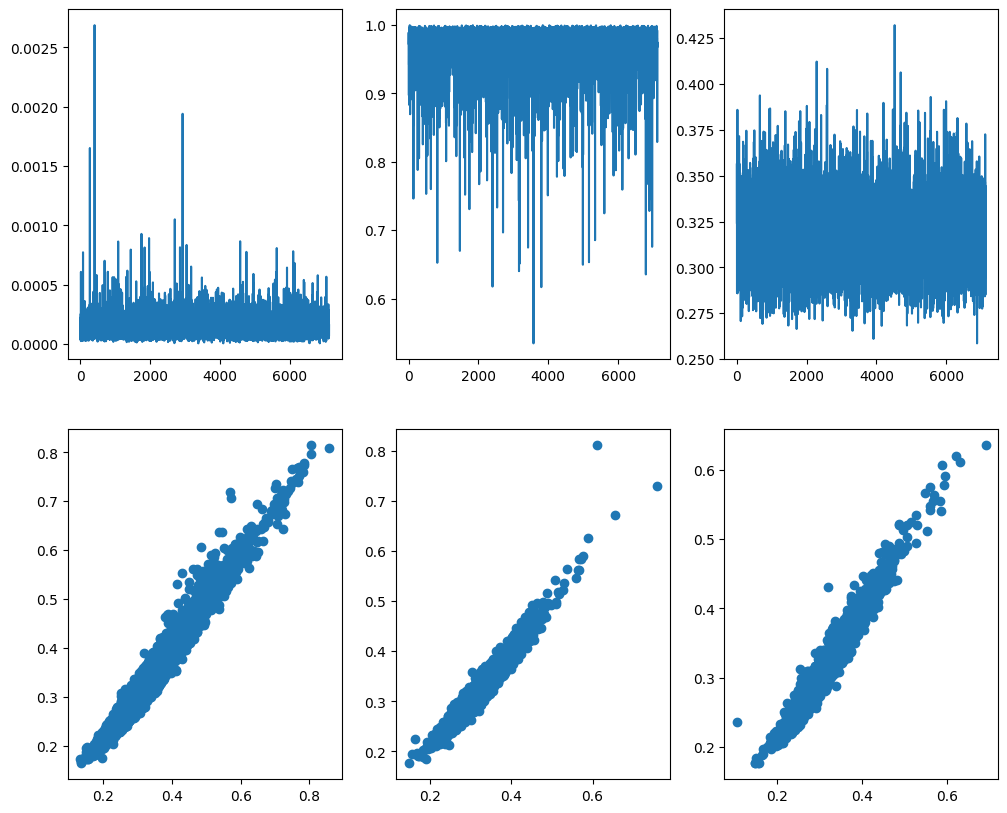

tensor(0.9773) tensor(0.9730) tensor(0.9717)
0.5856666666666667 0.5848684210526316


7125it [14:28,  8.20it/s]


9.2481224273478e-06


7125it [07:04, 16.78it/s]
375it [00:14, 26.06it/s]
475it [00:18, 25.18it/s]


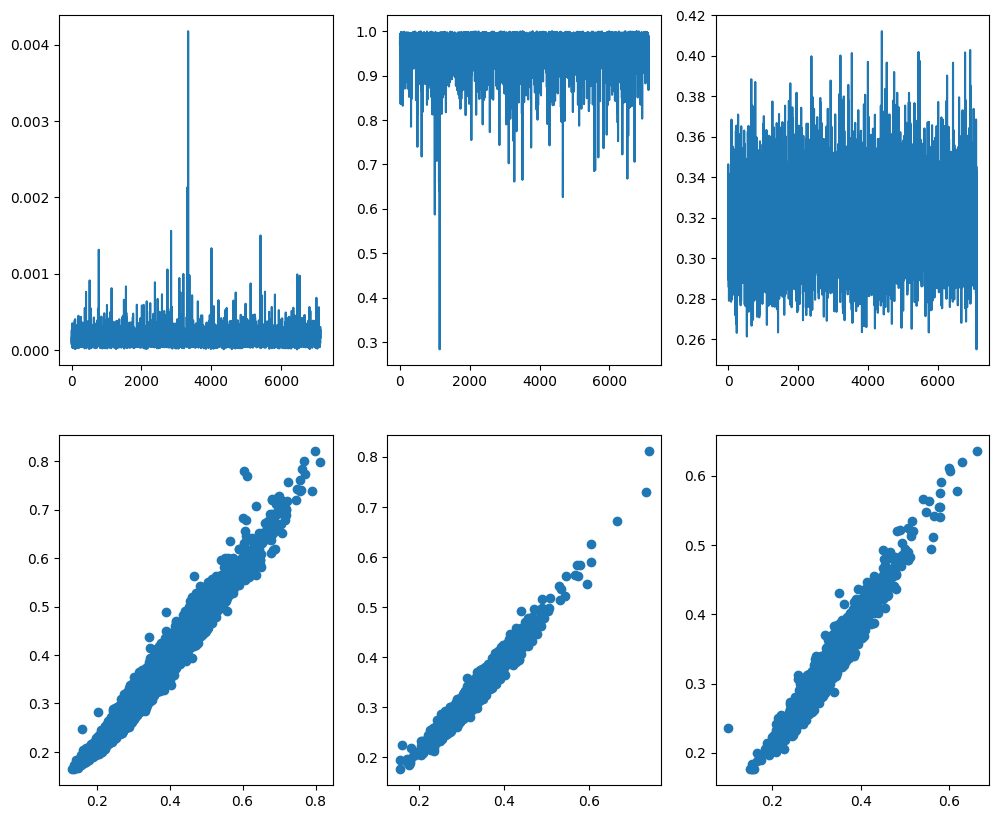

tensor(0.9777) tensor(0.9773) tensor(0.9722)
0.5963333333333334 0.6


7125it [14:29,  8.19it/s]


8.831837951172355e-06


7125it [07:05, 16.73it/s]
375it [00:14, 26.38it/s]
475it [00:18, 25.18it/s]


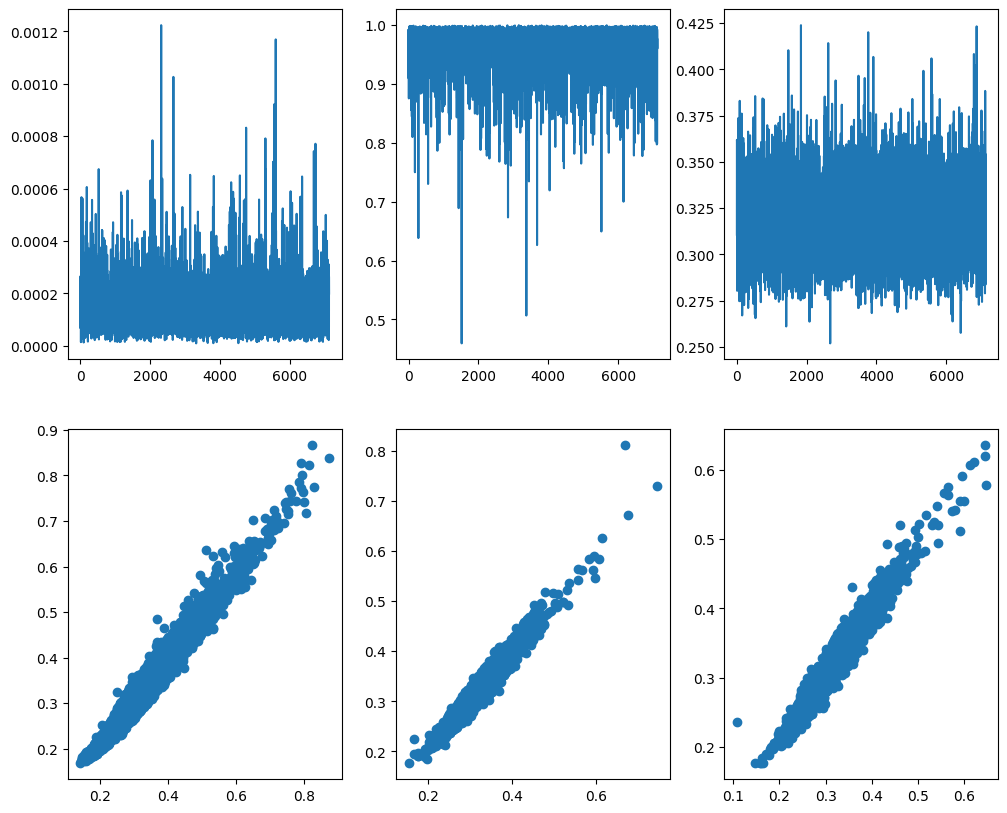

tensor(0.9772) tensor(0.9753) tensor(0.9716)
0.5765 0.5875


7125it [14:29,  8.20it/s]


8.600824964655898e-06


7125it [07:08, 16.63it/s]
375it [00:14, 25.94it/s]
475it [00:18, 25.11it/s]


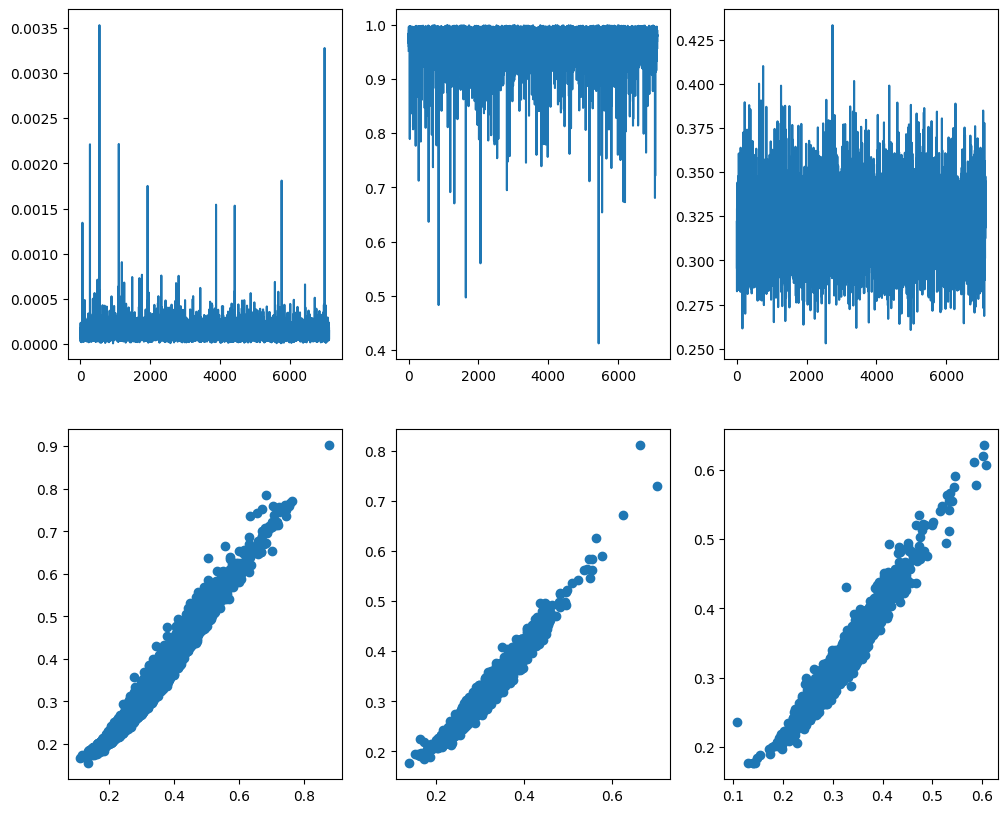

tensor(0.9763) tensor(0.9745) tensor(0.9696)
0.6095 0.6065789473684211


7125it [14:31,  8.18it/s]


8.420020192843687e-06


7125it [07:09, 16.61it/s]
375it [00:14, 25.84it/s]
475it [00:18, 25.07it/s]


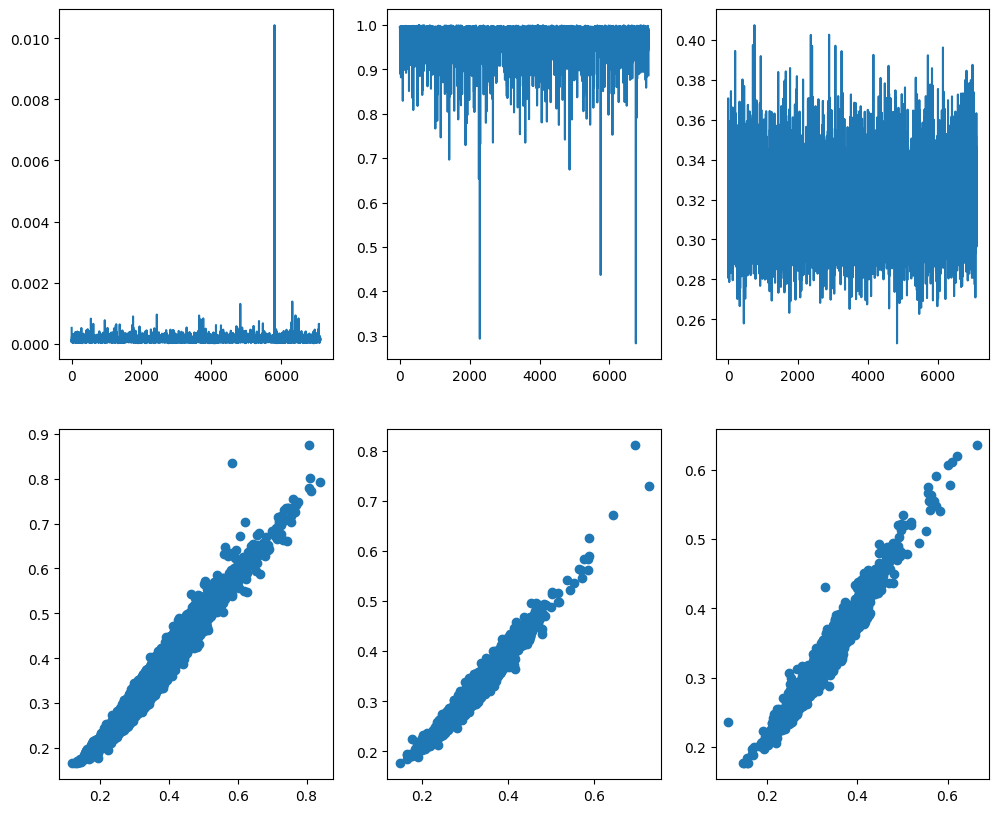

tensor(0.9785) tensor(0.9768) tensor(0.9739)
0.5868333333333333 0.5847368421052631


7125it [14:30,  8.19it/s]


8.347443371021974e-06


7125it [07:06, 16.73it/s]
375it [00:14, 25.70it/s]
475it [00:18, 25.32it/s]


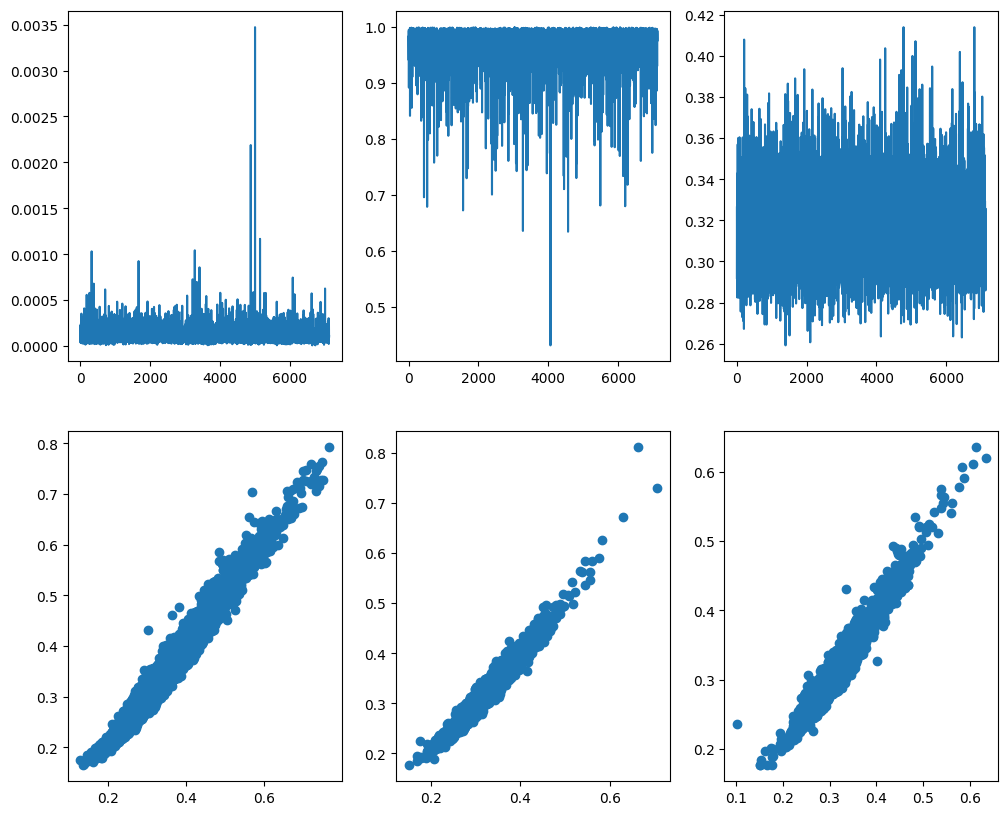

tensor(0.9774) tensor(0.9763) tensor(0.9717)
0.5873333333333334 0.5806578947368422


7125it [14:29,  8.20it/s]


9.225034831831037e-06


7125it [07:06, 16.69it/s]
375it [00:14, 25.93it/s]
475it [00:18, 25.24it/s]


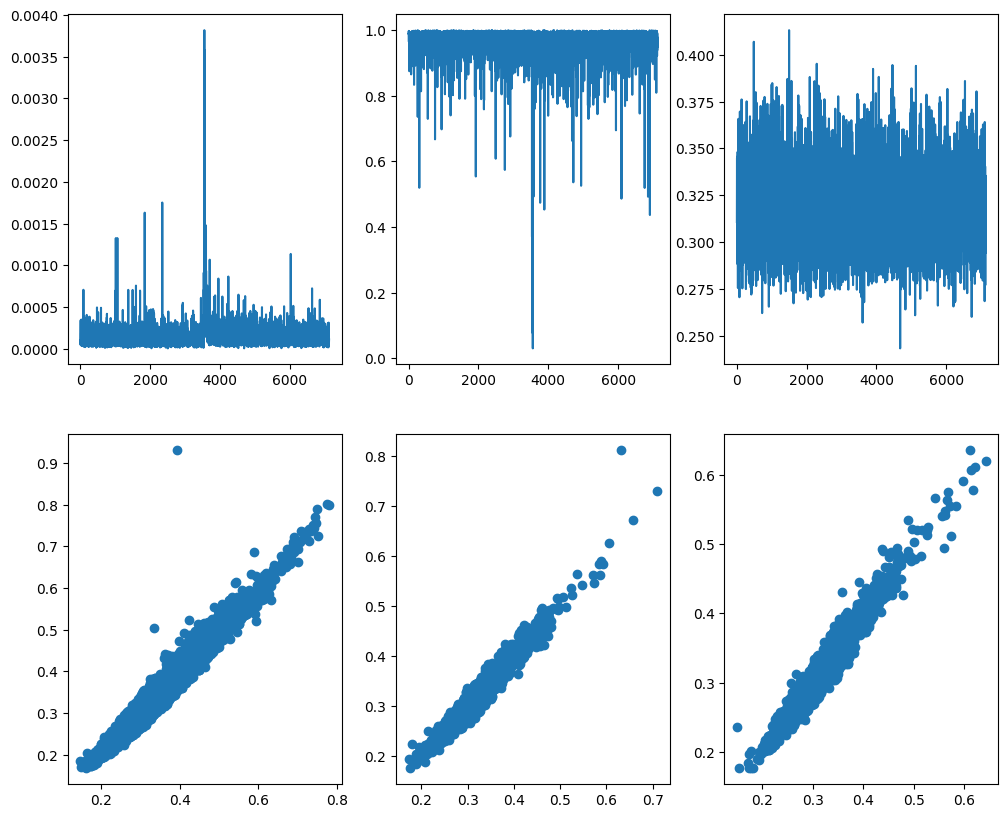

tensor(0.9761) tensor(0.9741) tensor(0.9716)
0.6001666666666666 0.5919736842105263


7125it [14:30,  8.19it/s]


8.076889101271502e-06


7125it [07:05, 16.74it/s]
375it [00:14, 25.91it/s]
475it [00:18, 25.25it/s]


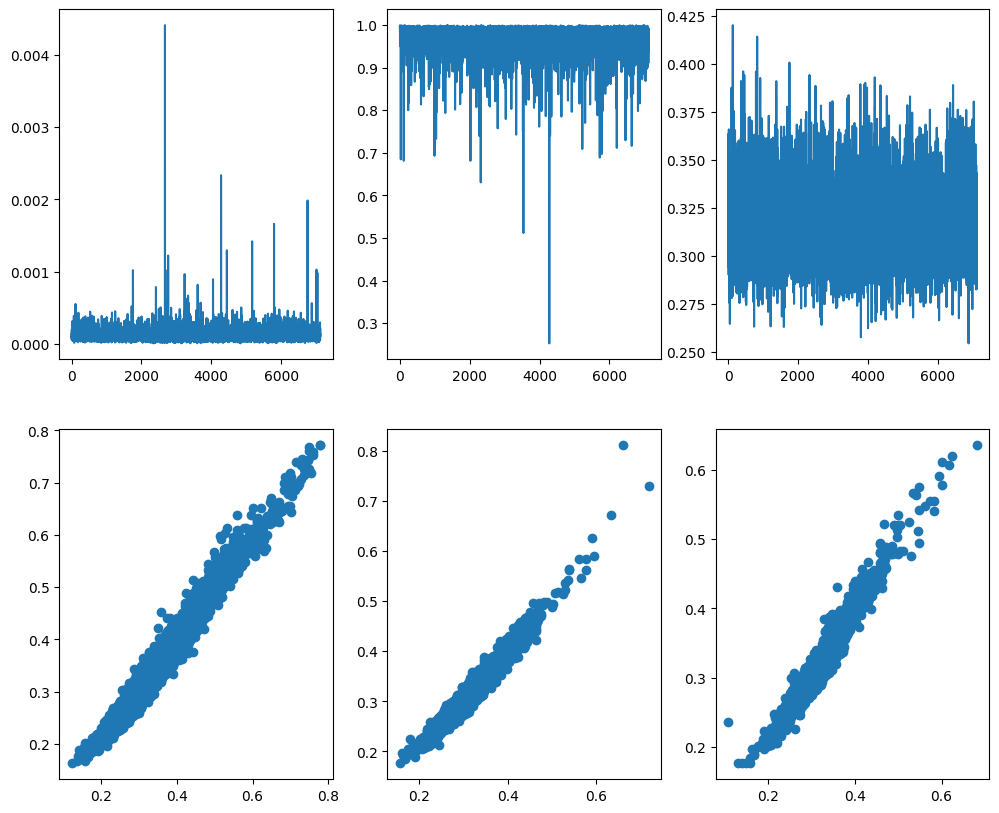

tensor(0.9789) tensor(0.9765) tensor(0.9737)
0.569 0.5713157894736842


7125it [14:29,  8.20it/s]


8.08303594847833e-06


7125it [07:05, 16.74it/s]
375it [00:14, 26.27it/s]
475it [00:18, 25.36it/s]


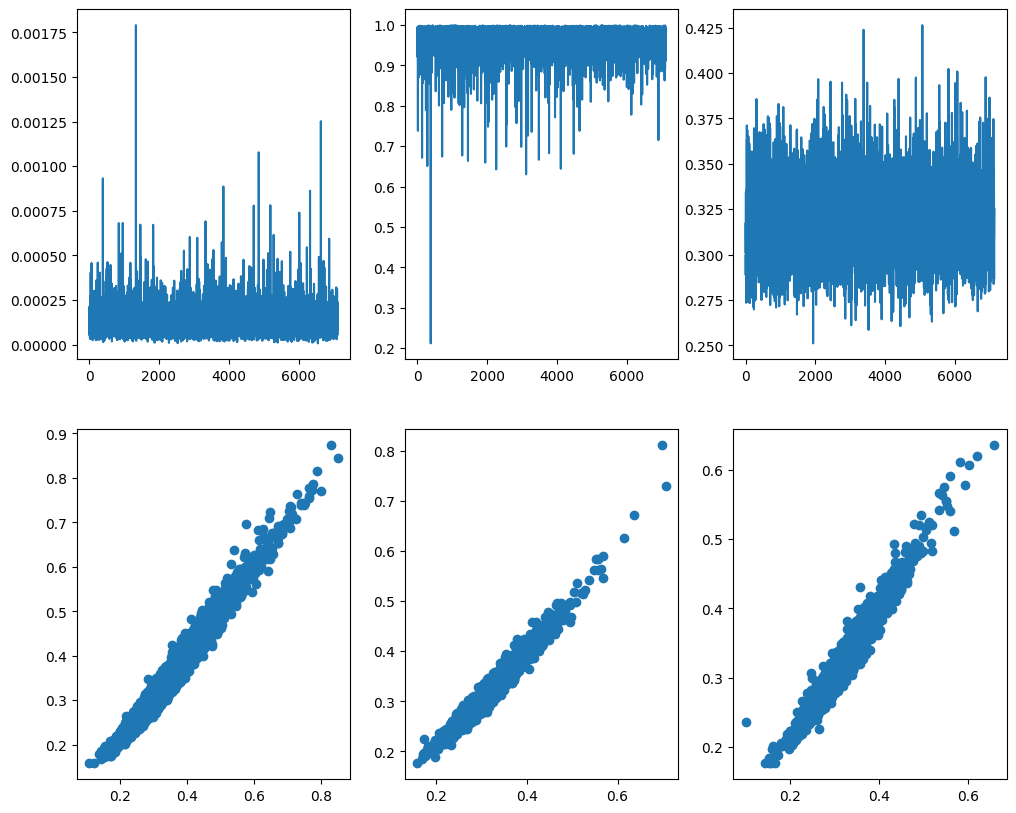

tensor(0.9806) tensor(0.9777) tensor(0.9740)
0.5818333333333333 0.5875


7125it [14:28,  8.21it/s]


8.262546221634406e-06


7125it [07:04, 16.77it/s]
375it [00:14, 25.92it/s]
475it [00:18, 25.32it/s]


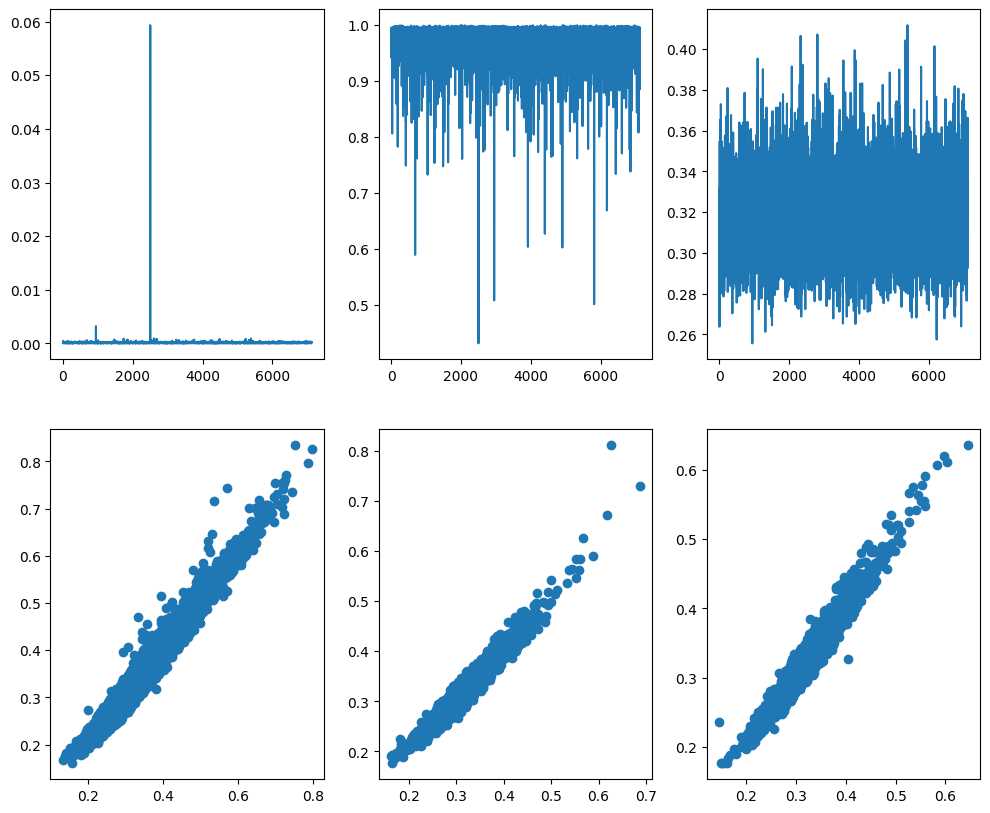

tensor(0.9765) tensor(0.9740) tensor(0.9731)
0.522 0.5107894736842106


7125it [14:29,  8.19it/s]


7.929619966054752e-06


7125it [07:05, 16.74it/s]
375it [00:14, 25.87it/s]
475it [00:18, 25.24it/s]


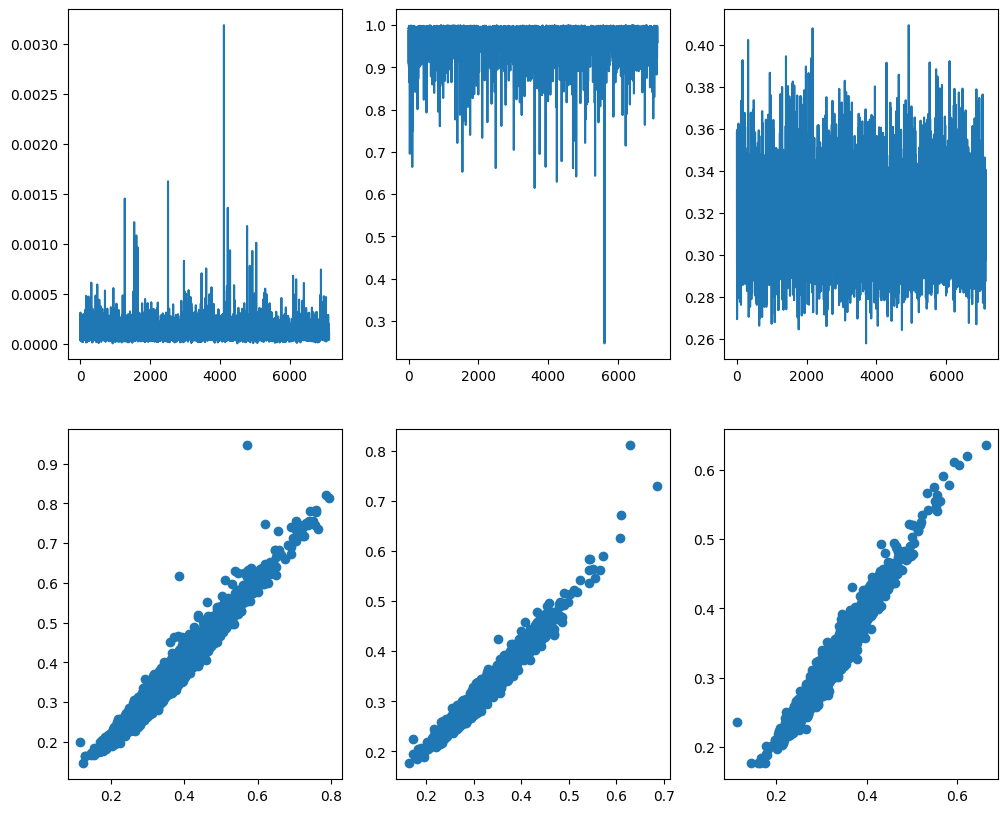

tensor(0.9777) tensor(0.9753) tensor(0.9741)
0.5731666666666667 0.5761842105263157


7125it [14:29,  8.20it/s]


8.366460209404785e-06


7125it [07:05, 16.75it/s]
375it [00:14, 25.95it/s]
475it [00:18, 25.32it/s]


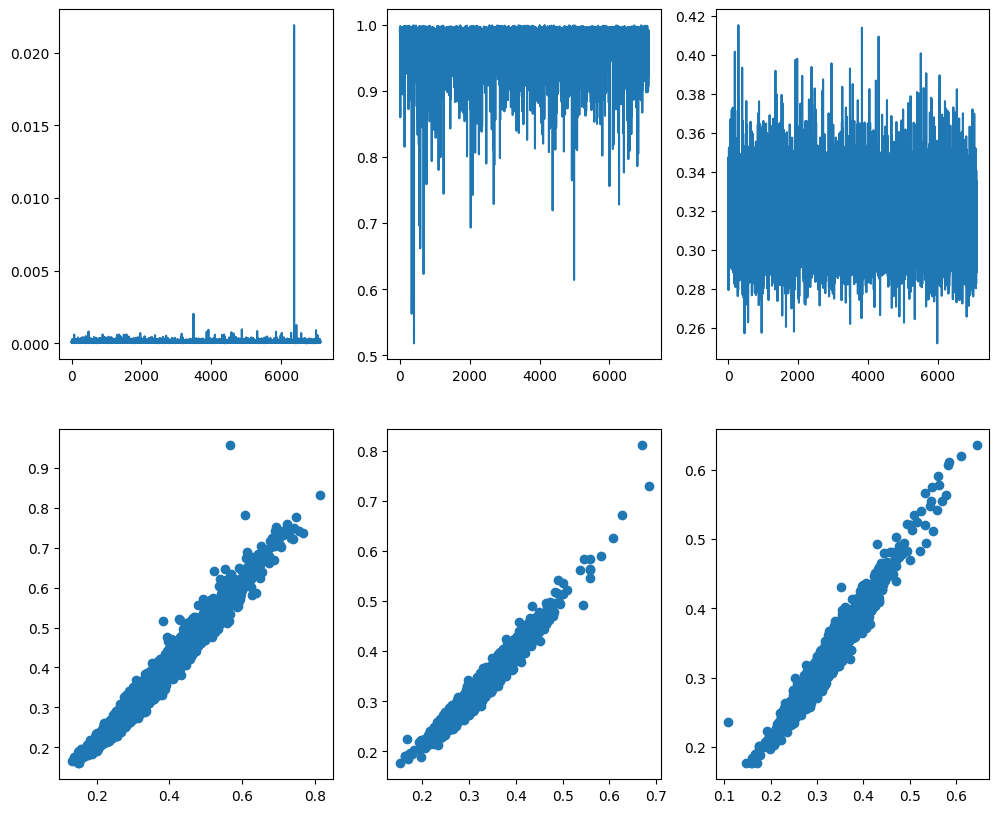

tensor(0.9789) tensor(0.9768) tensor(0.9745)
0.5608333333333333 0.5681578947368421


7125it [14:30,  8.18it/s]


7.672782320034394e-06


7125it [07:06, 16.71it/s]
375it [00:14, 25.91it/s]
475it [00:18, 25.30it/s]


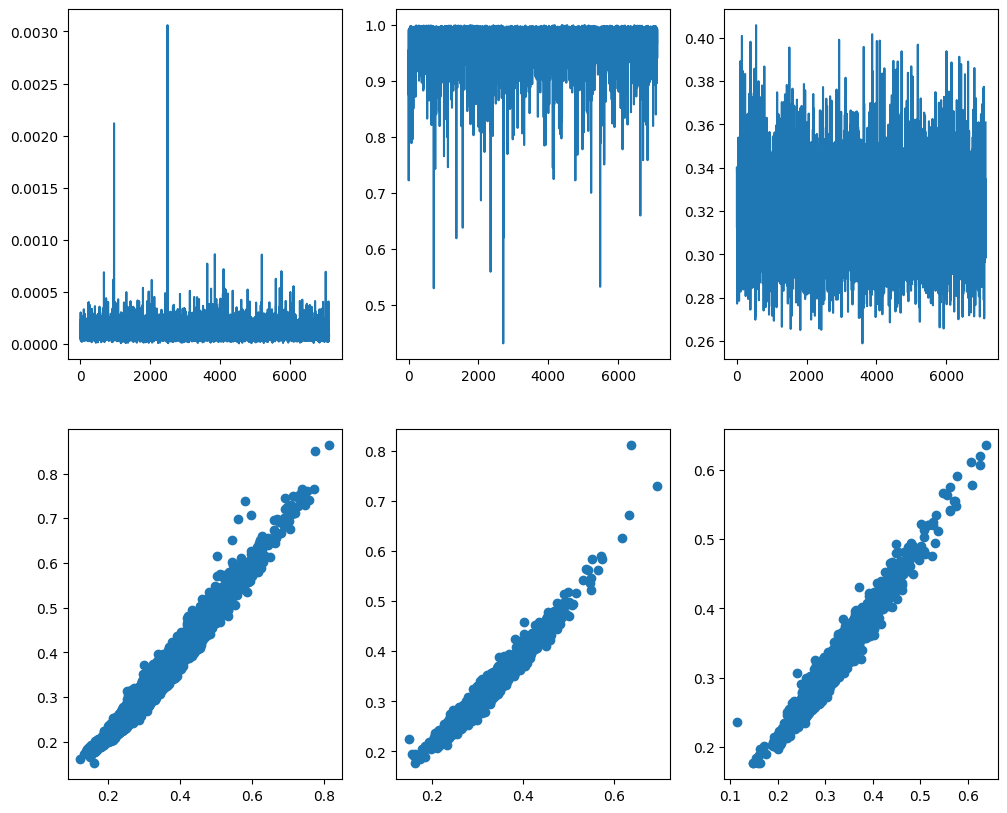

tensor(0.9804) tensor(0.9767) tensor(0.9762)
0.587 0.5819736842105263


7125it [14:29,  8.19it/s]


7.729158399646015e-06


7125it [07:04, 16.78it/s]
375it [00:14, 25.72it/s]
475it [00:18, 25.27it/s]


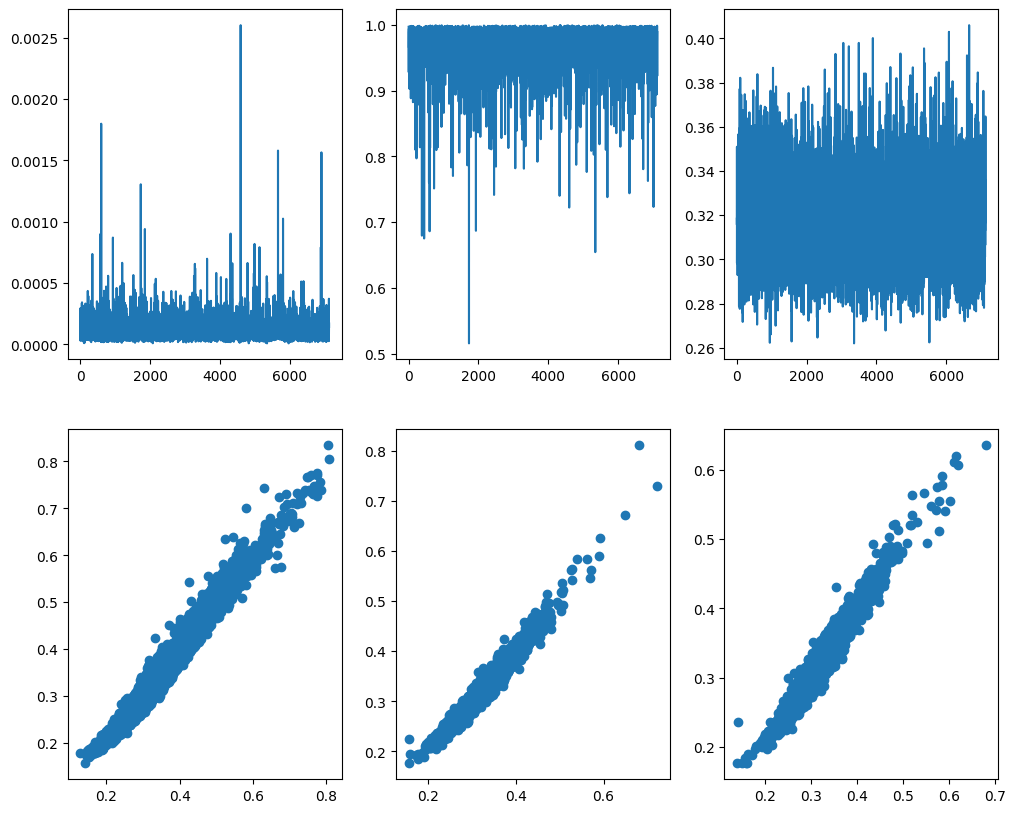

tensor(0.9794) tensor(0.9771) tensor(0.9744)
0.5625 0.5722368421052632


7125it [14:30,  8.19it/s]


7.4222633909676805e-06


7125it [07:06, 16.72it/s]
375it [00:14, 26.08it/s]
475it [00:18, 25.27it/s]


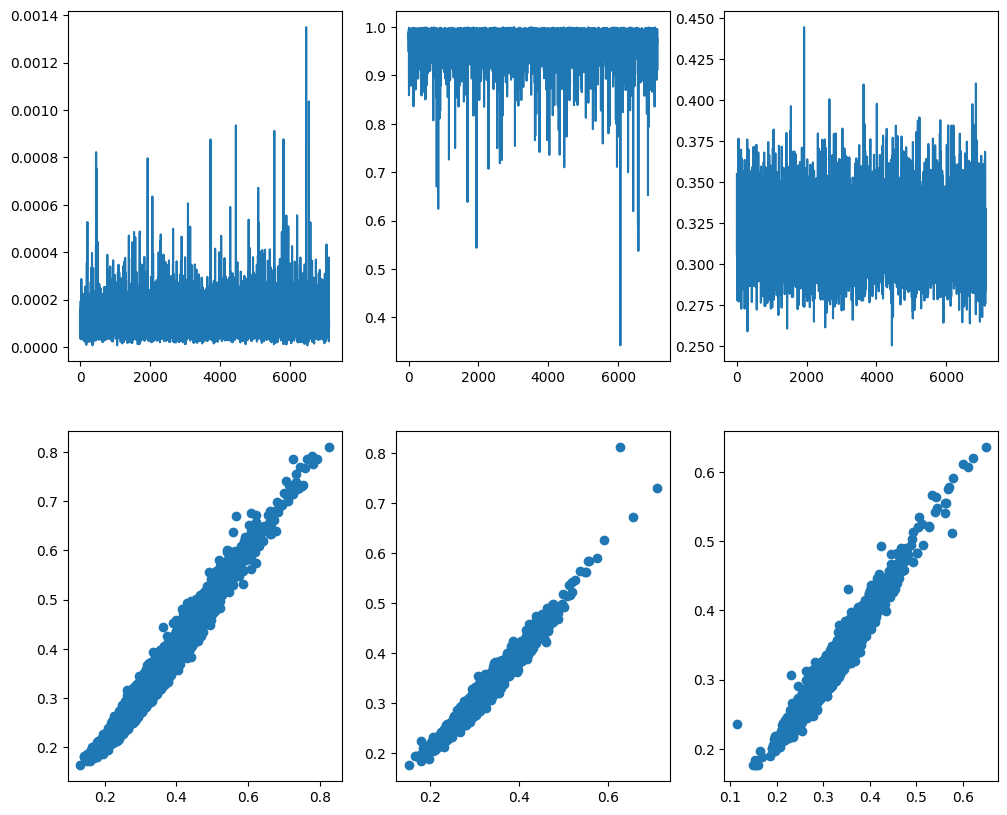

tensor(0.9801) tensor(0.9775) tensor(0.9749)
0.5626666666666666 0.5719736842105263


7125it [14:30,  8.19it/s]


7.427319826220219e-06


7125it [07:05, 16.74it/s]
375it [00:14, 26.19it/s]
475it [00:18, 25.27it/s]


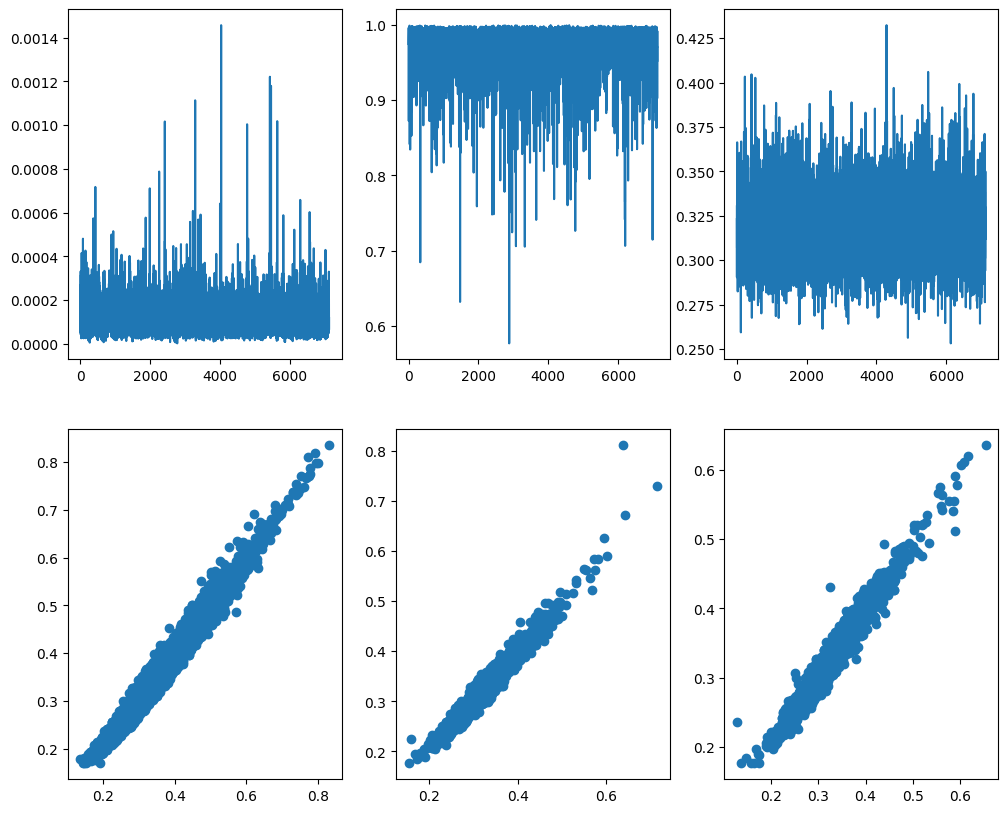

tensor(0.9813) tensor(0.9776) tensor(0.9757)
0.561 0.5643421052631579


7125it [14:29,  8.19it/s]


7.330818436018984e-06


7125it [07:04, 16.77it/s]
375it [00:14, 26.32it/s]
475it [00:18, 25.23it/s]


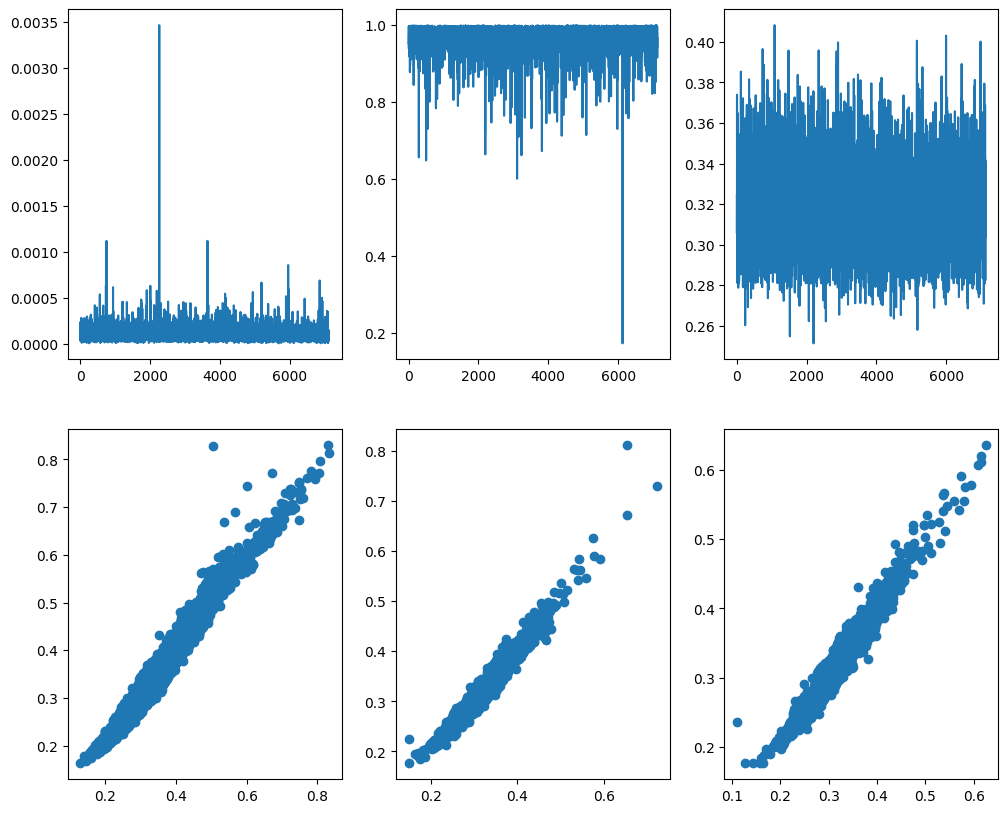

tensor(0.9807) tensor(0.9789) tensor(0.9763)
0.5343333333333333 0.5444736842105263


7125it [14:30,  8.19it/s]


7.128477736901723e-06


7125it [07:07, 16.66it/s]
375it [00:14, 26.00it/s]
475it [00:18, 25.12it/s]


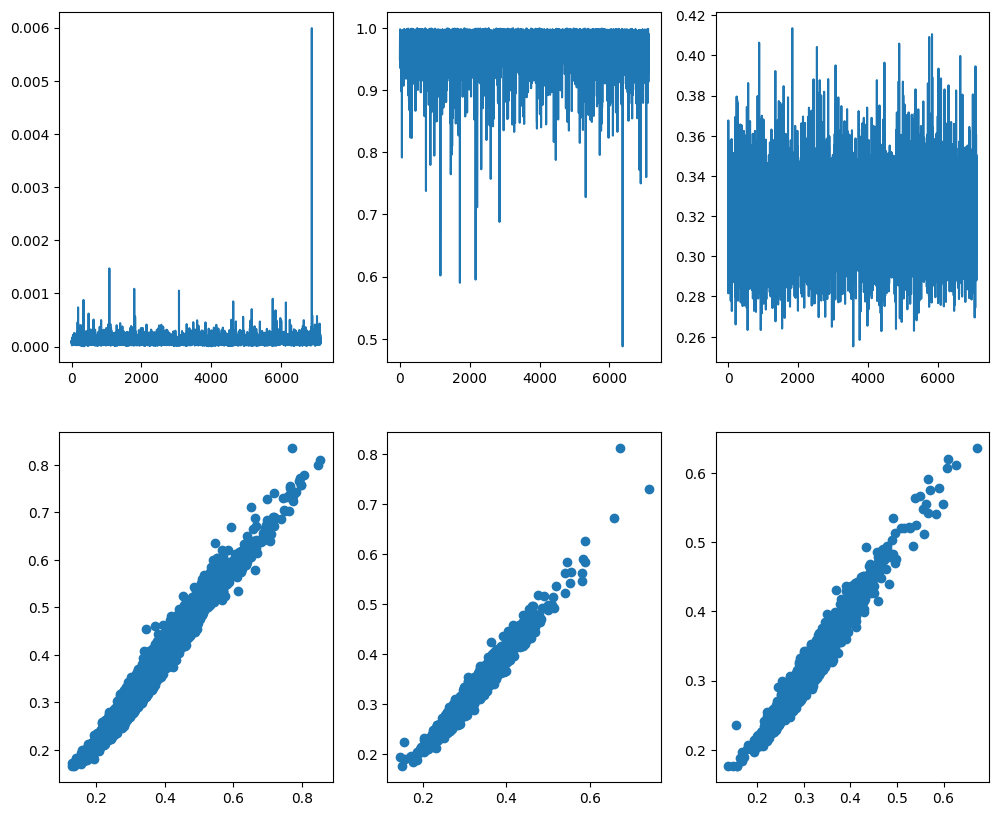

tensor(0.9796) tensor(0.9776) tensor(0.9761)
0.553 0.5513157894736842


7125it [14:28,  8.20it/s]


7.357546690982736e-06


7125it [07:03, 16.81it/s]
375it [00:14, 26.33it/s]
475it [00:18, 25.47it/s]


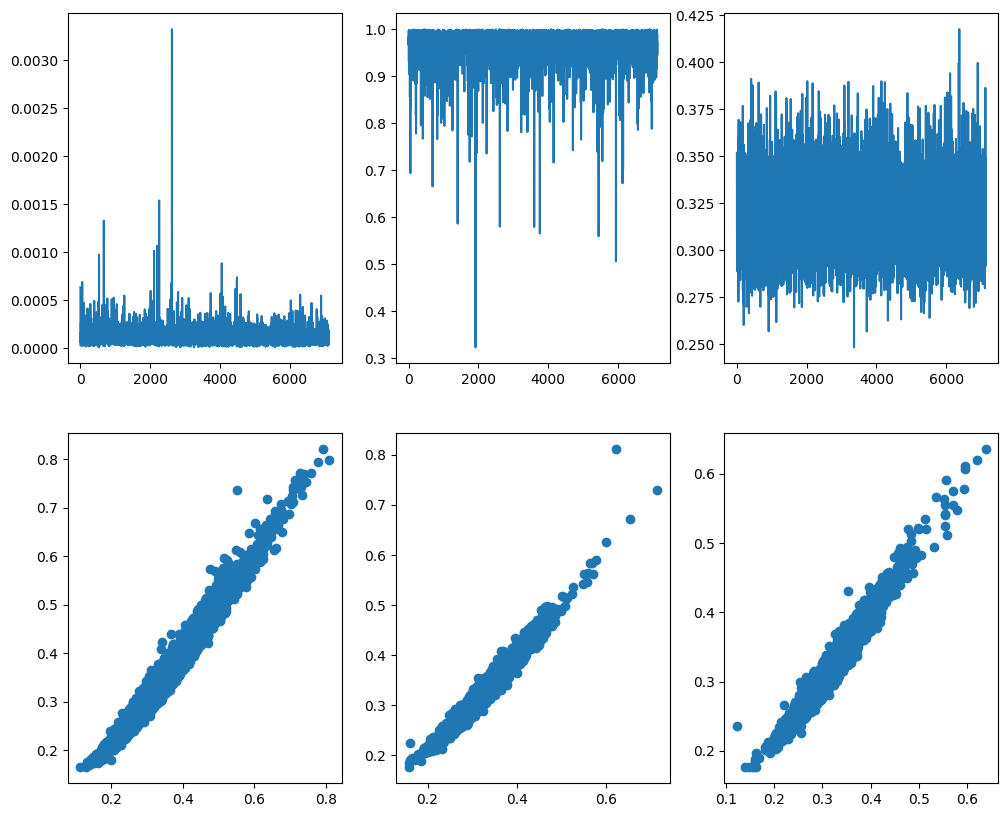

tensor(0.9816) tensor(0.9789) tensor(0.9772)
0.5388333333333334 0.5360526315789473


In [9]:
for _ in range(EPOCHS):
    loss_train, log = train(model, train_loader, criterion, optimizer, ssl = True)

    log = np.array(log)
    fig, axes = plt.subplots(2, 3, figsize = (12, 10))
    axes[0, 0].plot(log[:, 0]);
    axes[0, 1].plot(log[:, 1]);
    axes[0, 2].plot(log[:, 2]);

    print(loss_train)

    D_train = torch.empty(size = [0])
    D_val = torch.empty(size = [0])
    D_test = torch.empty(size = [0])
    NCD_train = torch.empty(size = [0])
    NCD_val = torch.empty(size = [0])
    NCD_test = torch.empty(size = [0])

    H_train = torch.empty(size = [0])
    H_val = torch.empty(size = [0])
    H_test = torch.empty(size = [0])
    y_train = torch.empty(size = [0])
    y_val = torch.empty(size = [0])
    y_test = torch.empty(size = [0])

    with torch.no_grad():
        for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(train_loader)):
            btsz = len(offsets) // 2
            h = model(label)
            delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
            D_train = torch.cat((D_train, delta.cpu()))
            NCD_train = torch.cat((NCD_train, ncd.cpu()))

            H_train = torch.cat((H_train, h.cpu()))
            y_train = torch.cat((y_train, classes.cpu()))

        for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(val_loader)):
            btsz = len(offsets) // 2
            h = model(label)
            delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
            D_val = torch.cat((D_val, delta.cpu()))
            NCD_val = torch.cat((NCD_val, ncd.cpu()))

            H_val = torch.cat((H_val, h.cpu()))
            y_val = torch.cat((y_val, classes.cpu()))

        for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(test_loader)):
            btsz = len(offsets) // 2
            h = model(label)
            delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
            D_test = torch.cat((D_test, delta.cpu()))
            NCD_test = torch.cat((NCD_test, ncd.cpu()))

            H_test = torch.cat((H_test, h.cpu()))
            y_test = torch.cat((y_test, classes.cpu()))

    axes[1, 0].scatter(D_train, NCD_train);
    axes[1, 1].scatter(D_val, NCD_val);
    axes[1, 2].scatter(D_test, NCD_test);
    plt.show()

    print(pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test))

    neigh = KNeighborsClassifier(n_neighbors = 2)
    neigh.fit(H_train, y_train);

    print(neigh.score(H_val, y_val), neigh.score(H_test, y_test))

    train_loader = ds.repair(BATCH_SIZE)

(1.4953795590324597e-05, tensor(0.9502))

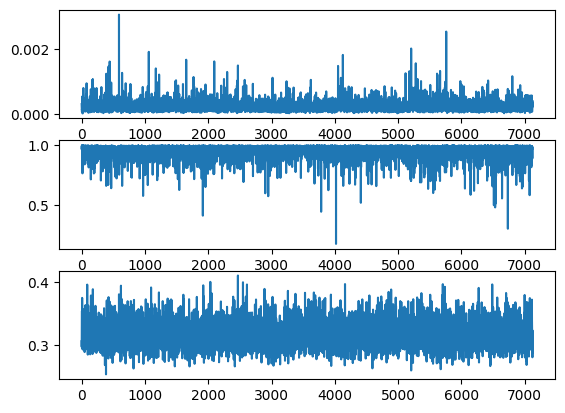

In [87]:
log = np.array(log)
fig, axes = plt.subplots(3)
axes[0].plot(log[:, 0]);
axes[1].plot(log[:, 1]);
axes[2].plot(log[:, 2]);
loss_train, corr_train

In [88]:
D_train = torch.empty(size = [0])
D_val = torch.empty(size = [0])
D_test = torch.empty(size = [0])

NCD_train = torch.empty(size = [0])
NCD_val = torch.empty(size = [0])
NCD_test = torch.empty(size = [0])

with torch.no_grad():
    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(train_loader)):
        btsz = len(offsets) // 2
        h = model(label)
        delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
        D_train = torch.cat((D_train, delta.cpu()))
        NCD_train = torch.cat((NCD_train, ncd.cpu()))

    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(val_loader)):
        btsz = len(offsets) // 2
        h = model(label)
        delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
        D_val = torch.cat((D_val, delta.cpu()))
        NCD_val = torch.cat((NCD_val, ncd.cpu()))

    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(test_loader)):
        btsz = len(offsets) // 2
        h = model(label)
        delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
        D_test = torch.cat((D_test, delta.cpu()))
        NCD_test = torch.cat((NCD_test, ncd.cpu()))

7125it [04:42, 25.23it/s]
375it [00:14, 26.27it/s]
475it [00:17, 26.62it/s]


(tensor(0.9524), tensor(0.9507), tensor(0.9453))

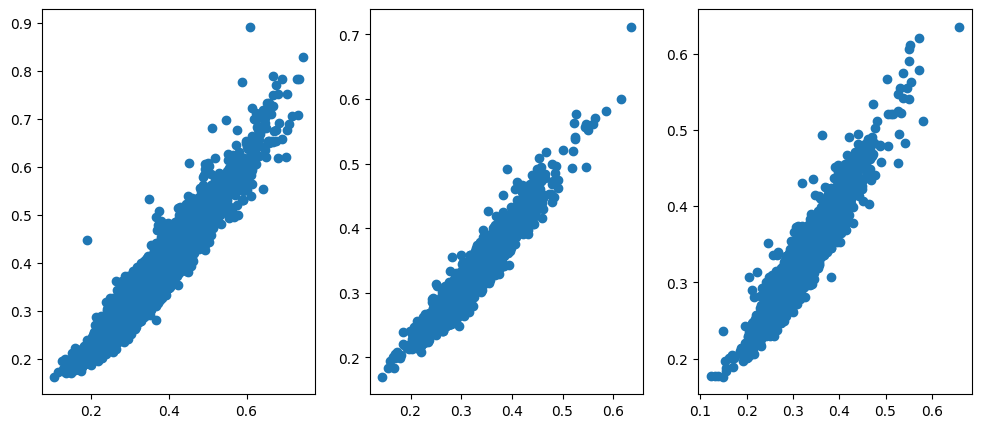

In [60]:
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].scatter(D_train, NCD_train);
axes[1].scatter(D_val, NCD_val);
axes[2].scatter(D_test, NCD_test);

pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test)

(tensor(0.9591), tensor(0.9566), tensor(0.9530))

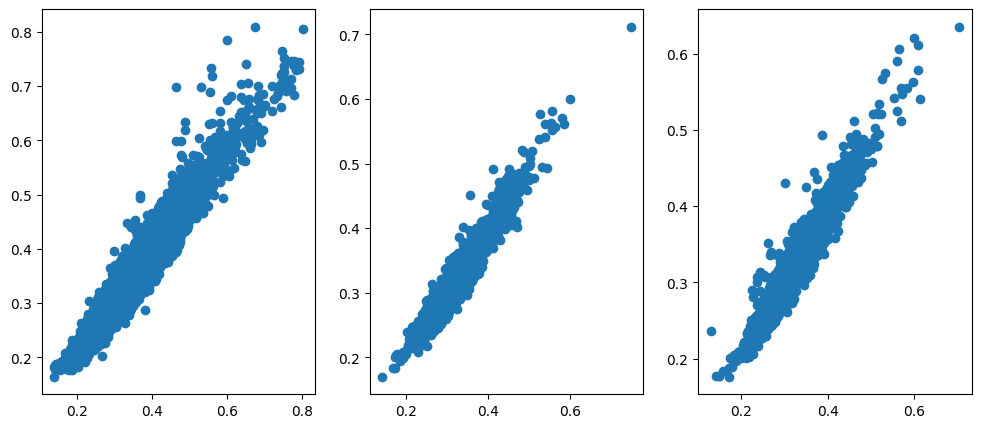

In [67]:
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].scatter(D_train, NCD_train);
axes[1].scatter(D_val, NCD_val);
axes[2].scatter(D_test, NCD_test);

pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test)

(tensor(0.9612), tensor(0.9580), tensor(0.9551))

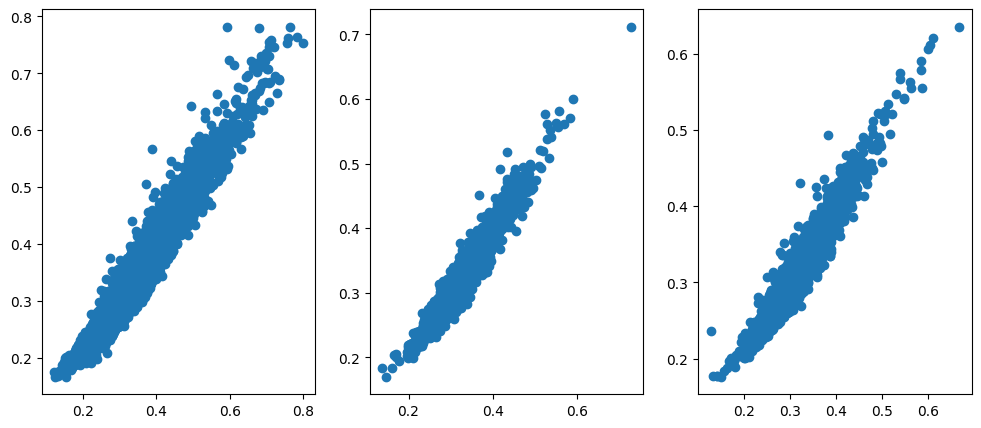

In [75]:
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].scatter(D_train, NCD_train);
axes[1].scatter(D_val, NCD_val);
axes[2].scatter(D_test, NCD_test);

pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test)

(tensor(0.9664), tensor(0.9617), tensor(0.9599))

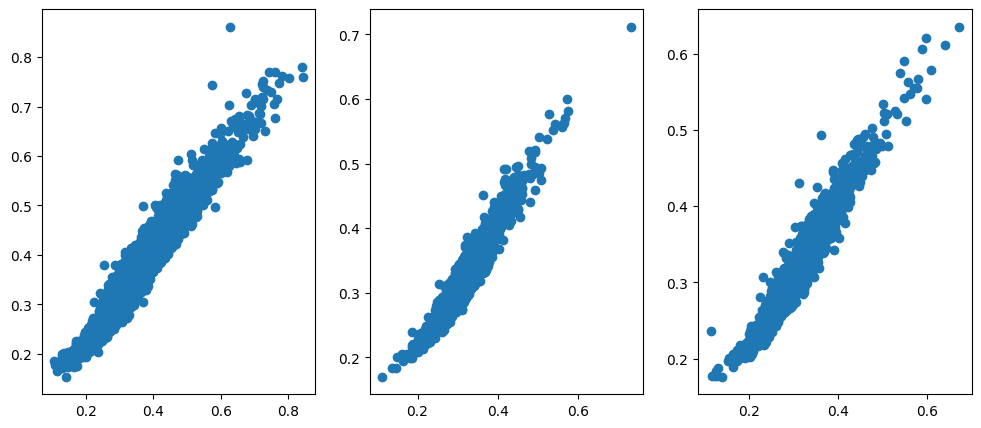

In [82]:
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].scatter(D_train, NCD_train);
axes[1].scatter(D_val, NCD_val);
axes[2].scatter(D_test, NCD_test);

pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test)

(tensor(0.9625), tensor(0.9570), tensor(0.9580))

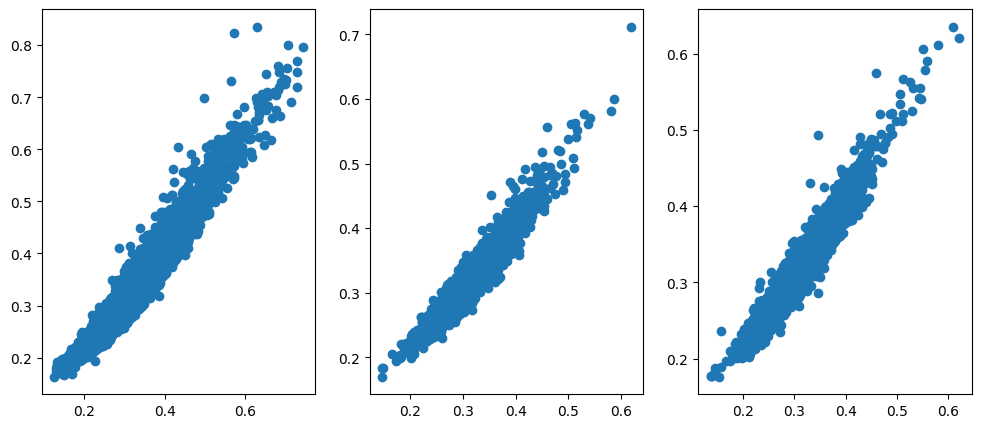

In [89]:
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].scatter(D_train, NCD_train);
axes[1].scatter(D_val, NCD_val);
axes[2].scatter(D_test, NCD_test);

pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test)

In [90]:
H_train = torch.empty(size = [0])
H_val = torch.empty(size = [0])
H_test = torch.empty(size = [0])

y_train = torch.empty(size = [0])
y_val = torch.empty(size = [0])
y_test = torch.empty(size = [0])

with torch.no_grad():
    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(train_loader)):
        h = model(label)
        H_train = torch.cat((H_train, h.cpu()))
        y_train = torch.cat((y_train, classes.cpu()))
        
    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(val_loader)):
        h = model(label)
        H_val = torch.cat((H_val, h.cpu()))
        y_val = torch.cat((y_val, classes.cpu()))

    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(test_loader)):
        h = model(label)
        H_test = torch.cat((H_test, h.cpu()))
        y_test = torch.cat((y_test, classes.cpu()))

7125it [07:04, 16.78it/s]
375it [00:13, 27.03it/s]
475it [00:17, 27.10it/s]


# clf

In [91]:
neigh = KNeighborsClassifier(n_neighbors = 2)
neigh.fit(H_train, y_train);

In [92]:
neigh.score(H_val, y_val), neigh.score(H_test, y_test)

(0.7048333333333333, 0.7030263157894737)